<a href="https://colab.research.google.com/github/Lutris98/PersonalProject_TradingBot/blob/main/2.Visualization/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install beautifulsoup4 
!pip install requests
!pip install mplfinance

In [62]:
from bs4 import BeautifulSoup 
import requests 

In [63]:
url='https://finance.naver.com/item/sise_day.nhn?code=068270'
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'}
response=requests.get(url, headers = headers).text

In [64]:
html=BeautifulSoup(response,'lxml') 
pgrr=html.find('td',class_='pgRR')
s=str(pgrr.a['href']).split('=')
last_page=s[-1] 

In [65]:
import pandas as pd
df=pd.DataFrame()
for page in range(1, int(last_page)+1): 
  page_url='{0}&page={1}'.format(url,page) 
  response=requests.get(page_url, headers = headers).text
  df=df.append(pd.read_html(response,header=0)[0]) 
df=df.dropna()

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3851 entries, 1 to 1
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      3851 non-null   object 
 1   종가      3851 non-null   float64
 2   전일비     3851 non-null   float64
 3   시가      3851 non-null   float64
 4   고가      3851 non-null   float64
 5   저가      3851 non-null   float64
 6   거래량     3851 non-null   float64
dtypes: float64(6), object(1)
memory usage: 240.7+ KB


In [67]:
df=df.rename(columns={'날짜':'Date','시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'}) #mpf에 맞게 OHLCV만 남기고 지움(날짜는 잠시 살려둠)
df.sort_values(by='Date') #날짜가 위가 높은 오름차순이게
candle_df=df.iloc[0:30]
candle_df

,Date,Close,전일비,Open,High,Low,Volume
1,2021.02.10,332000.0,4000.0,326500.0,332000.0,324500.0,724743.0
2,2021.02.09,328000.0,8000.0,336000.0,337500.0,328000.0,984780.0
3,2021.02.08,336000.0,5500.0,350000.0,351500.0,336000.0,784558.0
4,2021.02.05,341500.0,0.0,347500.0,355000.0,335000.0,1997418.0
5,2021.02.04,341500.0,6000.0,345000.0,349500.0,337500.0,1099579.0
9,2021.02.03,347500.0,8000.0,357500.0,359500.0,338000.0,1922464.0
10,2021.02.02,355500.0,15500.0,370000.0,370000.0,352500.0,2321590.0
11,2021.02.01,371000.0,47000.0,334000.0,383000.0,333000.0,6018601.0
12,2021.01.29,324000.0,10500.0,334500.0,339000.0,322500.0,1076910.0
13,2021.01.28,334500.0,5500.0,319500.0,338000.0,316000.0,1488920.0


In [68]:
import mplfinance as mpf
candle_df.index=pd.to_datetime(candle_df.Date) #index가 datetime형식이어야함 
candle_df=candle_df[['Open','High','Low','Close','Volume']]

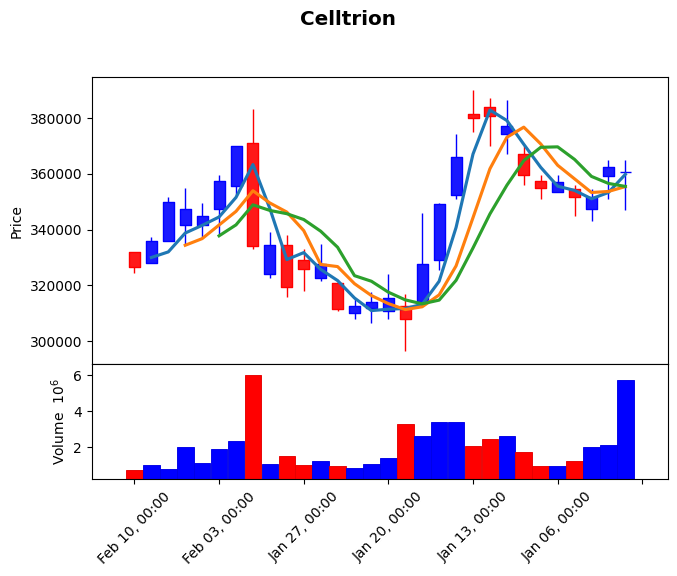

In [69]:
kwargs=dict(type='candle',mav=(2,4,6),volume=True,title='Celltrion',ylabel='Price') #한국어 지원 안됨ㅠ
mc=mpf.make_marketcolors(up='r',down='b',inherit=True) 
s=mpf.make_mpf_style(marketcolors=mc)
mpf.plot(candle_df,**kwargs,style=s)